# Vectorized Backtesting
In this exercise we build from scratch a simple **backtesting** system to test the profitability of a **simple trading strategy** on the S&P 500.

As usual we start from **importing** the standard **packages**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10 
plt.rcParams['lines.linewidth'] = 3
%matplotlib inline

When we build a strategy we normally follow a series of steps:
1. We import and clean the **data**
1. We build the **signal** that we use to forecast returns, our "Alpha Model"
1. We pass the signal to our Portfolio Construction model that will transform the signal in a **position**

___
## 1. The Data
We then **load our data** from the file used in the [Chapter 4](https://learning.oreilly.com/library/view/python-for-algorithmic/9781492053347/ch04.html) of the Hilpisch _Python for Algorithmic Trading_ book.

**ATTENTION:** Please notice how flexible the data loading functions in Pandas are. We can load a file from anywhere on the web just by passing the address of the file!

In [2]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', 
                  index_col='Date', parse_dates=['Date']).dropna() # the .dropna() method drops all the missing values
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


Let's now extract the **Euro/USD** exchange rate into its own DataFrame. We could keep it as a series, but as you will see, in this case a DataFrame is more convenient, so we we use the **[`Series.to_frame()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_frame.html)** method to transform it into a DataFrame with a single column.

In [3]:
data = raw['EUR='].to_frame()
data.head()

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


We can then **plot** this series to get the feel for it:

<Axes: title={'center': 'EUR/USD'}, xlabel='Date'>

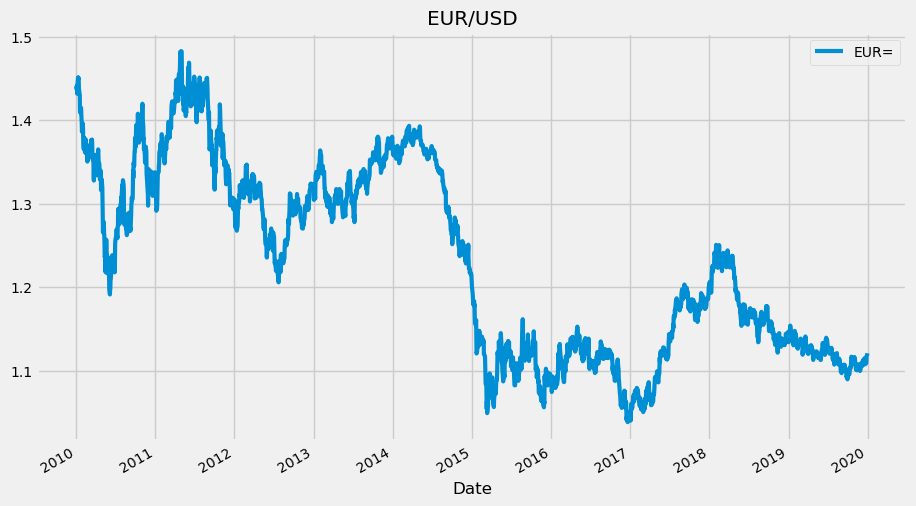

In [4]:
data.plot(figsize=(10, 6),
          title='EUR/USD')

___
## 2. The Signal
The goal of this exercise is not so much to introduce a successful investment strategy, but to show **how to build a backtesting system for a generic strategy**. So, to start, we will implement one of the oldest trading strategies, the so-called [Moving-Average Crossover Strategy](https://en.wikipedia.org/wiki/Moving_average_crossover).

The starting point is to create two Moving Average Indicators using the **[`DataFrame.rolling()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)** method that allows us to perform a number of calculations on a rolling window. 

In [5]:
data['SMA1'] = data['EUR='].rolling(42).mean()
data['SMA2'] = data['EUR='].rolling(252).mean()
data.tail()

,EUR=,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


<Axes: title={'center': 'EUR/USD | 42 & 252 days SMAs'}, xlabel='Date'>

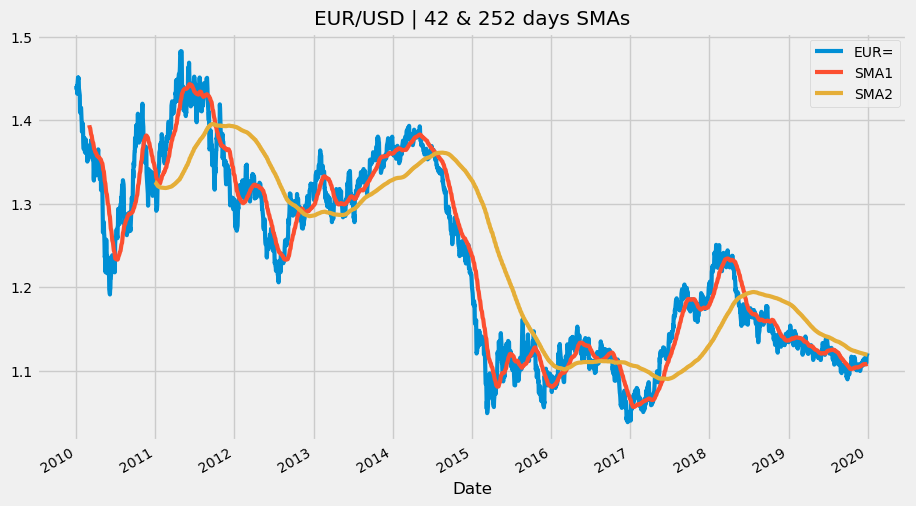

In [6]:
data.plot(figsize=(10, 6),
          title='EUR/USD | 42 & 252 days SMAs')

The key element of every strategy is the **Alpha Model**. In a SMA strategy, this is quite trivial: when **the short-term MA is above the long-term MA** we predict that the price will rise. So our **Signal** will simply be the difference between the two rolling moving averages.

<Axes: title={'center': 'SMA Signal'}, xlabel='Date'>

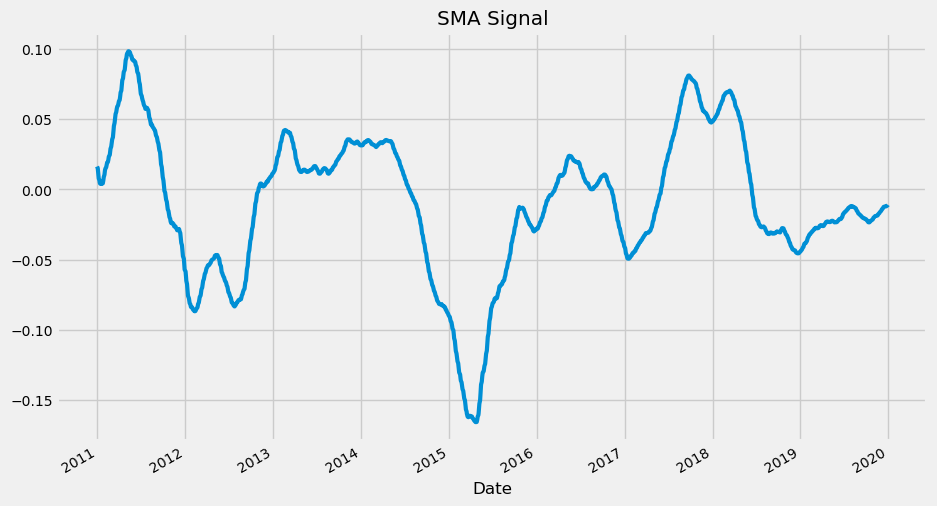

In [7]:
data['signal'] = data['SMA1'] - data['SMA2']

data['signal'].plot(figsize=(10, 6),
                    title='SMA Signal')

Techically the SMA strategy does not look at the size of the difference between the two MAs, but only at the sign. We could have defined our signal as
```python
data['signal'] = data['SMA1'] > data['SMA2']
```

This would have given us a "boolean" signal (`True/False`) and that would have been sufficient. The solution we used above allows us to more easily plot the signal, and provide some modicum of additional information. For example we can see "how close" the signal is to reverse.

___
## 3. The Position
Our **Portfolio Construction Model** will take the signal and transform it into a trading position. Given the introductory nature of this example, also our portfolio model is trivial: we buy when we forecast a price increase (positive signal) and we go short when we forecast a decrease (negative signal).

The coding is also trivial because in NumPy we have a function **[`np.sign()`](https://numpy.org/doc/stable/reference/generated/numpy.sign.html)** that transforms any number into a sign indicator. Specifically given a number $n$, the signal function will return:
- `+1` if $n>0$
- `0` if $n=0$
- `-1` if $n<0$

In [8]:
data['position'] = np.sign(data['signal'])
data.tail()

,EUR=,SMA1,SMA2,signal,position
Date,,,,,
2019-12-24,1.1087,1.107698,1.119630,-0.011933,-1.0
2019-12-26,1.1096,1.107740,1.119529,-0.011788,-1.0
2019-12-27,1.1175,1.107924,1.119428,-0.011504,-1.0
2019-12-30,1.1197,1.108131,1.119333,-0.011202,-1.0
2019-12-31,1.1210,1.108279,1.119231,-0.010952,-1.0


This is the core element of a **Vectorized Backtesting** as you can see we can determine the value of the position (in this case simply long/short) **simultaneously for all days**. This is called a _vectorized_ calculation because we only need one line of code and we apply it to the entire vector of prices. 

We can use the method [**`DataFrame.value_counts()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) to count the frequency of values in a column. This will tell us how many days we held long and short position in the exchange rate.

In [9]:
data['position'].value_counts()

-1.0    1216
 1.0    1049
Name: position, dtype: int64

___
### Coding Issue
In the from [Chapter 4](https://learning.oreilly.com/library/view/python-for-algorithmic/9781492053347/ch04.html) of the Hilpisch _Python for Algorithmic Trading_ book it uses a more general method based on the numpy function [**`np.where()`**](https://numpy.org/doc/stable/reference/generated/numpy.where.html):

In [10]:
data['position2'] = np.where(data['SMA1'] > data['SMA2'],1, -1) 
data.tail()

,EUR=,SMA1,SMA2,signal,position,position2
Date,,,,,,
2019-12-24,1.1087,1.107698,1.119630,-0.011933,-1.0,-1
2019-12-26,1.1096,1.107740,1.119529,-0.011788,-1.0,-1
2019-12-27,1.1175,1.107924,1.119428,-0.011504,-1.0,-1
2019-12-30,1.1197,1.108131,1.119333,-0.011202,-1.0,-1
2019-12-31,1.1210,1.108279,1.119231,-0.010952,-1.0,-1


Probably, with some time and wasted effort **we could find three or four more**. The idea is that as long as it works...it works. Pick one and stick with it. To keep our DataFrame "clean" let's drop this last column since we will not need it moving forward. We can "Drop stuff" from a DataFrame by using the method **[`DataFrame.drop()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)**:

In [11]:
data = data.drop(columns=['position2'])
data.tail()

,EUR=,SMA1,SMA2,signal,position
Date,,,,,
2019-12-24,1.1087,1.107698,1.119630,-0.011933,-1.0
2019-12-26,1.1096,1.107740,1.119529,-0.011788,-1.0
2019-12-27,1.1175,1.107924,1.119428,-0.011504,-1.0
2019-12-30,1.1197,1.108131,1.119333,-0.011202,-1.0
2019-12-31,1.1210,1.108279,1.119231,-0.010952,-1.0


### Recap
As you can see we have built our trading strategies by:
1. Creating a **Signal** that forecasts the movement of our asset (US Dollar). This is our Alpha Model!
1. Transforming our Signal into a **trading Position**. In this case the position is simply binary (go long vs go short on the Dollar). We could have implemented a more complex strategy where the "size" of the bet was calculated as a function of the signal.

___
## 4. The Performance
After building our strategy we need to **measure its performance** and compare it with a **suitable benchmark**. 

To calculate the performance of the strategy, we need to build the **[log returns](https://en.wikipedia.org/wiki/Rate_of_return#Logarithmic)** of the asset in the **next period**.

$$ r_{t, t+1} = \log \left(\frac{P_{t+1}}{P_{t}}\right)$$

The code to do this is again rather concise due to vectorization. The calculation below makes use of the method **[`Series.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.shift.html)** to extract the prices in the "next" day. Please notice that shift works **backwards** so, to move forward, we need to shift by a **negative number**.

In [12]:
data['future_returns'] = np.log(data['EUR='].shift(-1) / data['EUR='])
data.tail()

,EUR=,SMA1,SMA2,signal,position,future_returns
Date,,,,,,
2019-12-24,1.1087,1.107698,1.119630,-0.011933,-1.0,0.000811
2019-12-26,1.1096,1.107740,1.119529,-0.011788,-1.0,0.007094
2019-12-27,1.1175,1.107924,1.119428,-0.011504,-1.0,0.001967
2019-12-30,1.1197,1.108131,1.119333,-0.011202,-1.0,0.001160
2019-12-31,1.1210,1.108279,1.119231,-0.010952,-1.0,NaN


To calculate the **return of the strategy** we need to multiply by the position in time $t$ by the return of the day $t+1$.

In [13]:
data['strategy'] = data['position'] * data['future_returns']
data.tail()

,EUR=,SMA1,SMA2,signal,position,future_returns,strategy
Date,,,,,,,
2019-12-24,1.1087,1.107698,1.119630,-0.011933,-1.0,0.000811,-0.000811
2019-12-26,1.1096,1.107740,1.119529,-0.011788,-1.0,0.007094,-0.007094
2019-12-27,1.1175,1.107924,1.119428,-0.011504,-1.0,0.001967,-0.001967
2019-12-30,1.1197,1.108131,1.119333,-0.011202,-1.0,0.001160,-0.001160
2019-12-31,1.1210,1.108279,1.119231,-0.010952,-1.0,NaN,NaN


### 4.1 The Benchmark 
It is always diffcult to assess the quality of a portfolio strategy in isolation. We always look for a **"neutral portfolio"** to be used as **comparison**. For example if your strategy is designed to select the "best stocks" on the US market, you may want to use the S&P 500 as your "neutral portfolio" or **Benchmark**. The idea is that you could save the cost of building your strategy and simply invest in every major US company...

Here the most intuitive "neutral portfolio", is one where we **go long every day** without choosing wheter we should go long or short. We can easily:
- Build te Benchmark
- Calculate its return
- Calculate the "Active" return of the portfolio as the return above the Benchmark (above the "dumb" strategy). 

In [14]:
data['Benchmark'] = 1
data['Bench_ret'] = data['Benchmark']*data['future_returns']
data.tail()

,EUR=,SMA1,SMA2,signal,position,future_returns,strategy,Benchmark,Bench_ret
Date,,,,,,,,,
2019-12-24,1.1087,1.107698,1.119630,-0.011933,-1.0,0.000811,-0.000811,1,0.000811
2019-12-26,1.1096,1.107740,1.119529,-0.011788,-1.0,0.007094,-0.007094,1,0.007094
2019-12-27,1.1175,1.107924,1.119428,-0.011504,-1.0,0.001967,-0.001967,1,0.001967
2019-12-30,1.1197,1.108131,1.119333,-0.011202,-1.0,0.001160,-0.001160,1,0.001160
2019-12-31,1.1210,1.108279,1.119231,-0.010952,-1.0,NaN,NaN,1,NaN


### 4.2 The Diagnostics
Now that we have the daily performance of our portfolio we can calculate the **usual diagnostics**:
- Mean Return
- Total Retrurn
- Standard Deviation
- Sharpe Ratio

In [15]:
# we can look at mean returns (annualized)
mean_ret = data[['Bench_ret', 'strategy']].mean()*252
mean_ret

Bench_ret   -0.025168
strategy     0.028174
dtype: float64

In [16]:
# since we are using log-returns, the total return is simply the sum of the daily returns
tot_ret = data[['Bench_ret', 'strategy']].sum()
tot_ret

Bench_ret   -0.251186
strategy     0.253121
dtype: float64

In [17]:
# we can look at the standard deviation (annualized)
st_dev = data[['Bench_ret', 'strategy']].std()*np.sqrt(252)
st_dev

Bench_ret    0.089465
strategy     0.085405
dtype: float64

In [18]:
# finally the annualized Sharpe Ratio (or return-to-risk ratio)
sharpe = mean_ret/st_dev
sharpe

Bench_ret   -0.281322
strategy     0.329890
dtype: float64

### 4.3 Plotting the Performance
We can also plot the performance of the portfolio. To do this, we need to convert monthly returns into a series of portfolio prices. Since we are using logarithmic returns this is trivial. We know that if an asset has, in three periods, returns equal to $r_{1}$, $r_{2}$ and $r_{3}$, than the return from time 0 to time 3 is simply the sum
$$r_{0, 3} = \sum_{t=1}^{3}r_{t}$$

And we also know that the dollar value at the end of time 3 of a $1 investment in time 0 is

$$W_{3} = \$1\times e^{r_{0, 3}}$$

We can simply apply the Numpy exponential function **[`numpy.exp()`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html)** to the cumulative returns calculated using the **[`DataFrame.cumsum()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html)** method.

The following command is a typical example of the power and flexibility, and sometimes confusion, of using _[method chaining](https://www.kaggle.com/code/residentmario/method-chaining-reference)_ in Pandas. Here we are:
1. Taking two columns from the DataFrame `data`
1. Dropping all the rows with missing observations with the **[`DataFrame.dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)** method.
1. Applying the cumulative sum operator **[`DataFrame.cumsum()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html)** to the "clean" dataset.
1. Applying the exponential function **[`numpy.exp()`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html)** to this cumulative sum.

In [19]:
port_values = data[['Bench_ret', 'strategy']].dropna().cumsum().apply(np.exp)
port_values.head()

,Bench_ret,strategy
Date,,
2010-12-31,0.998056,0.998056
2011-01-03,0.994319,0.994319
2011-01-04,0.983105,0.983105
2011-01-05,0.971892,0.971892
2011-01-06,0.965538,0.965538


<Axes: title={'center': 'USD Strategy'}, xlabel='Date', ylabel='Portfolio Value'>

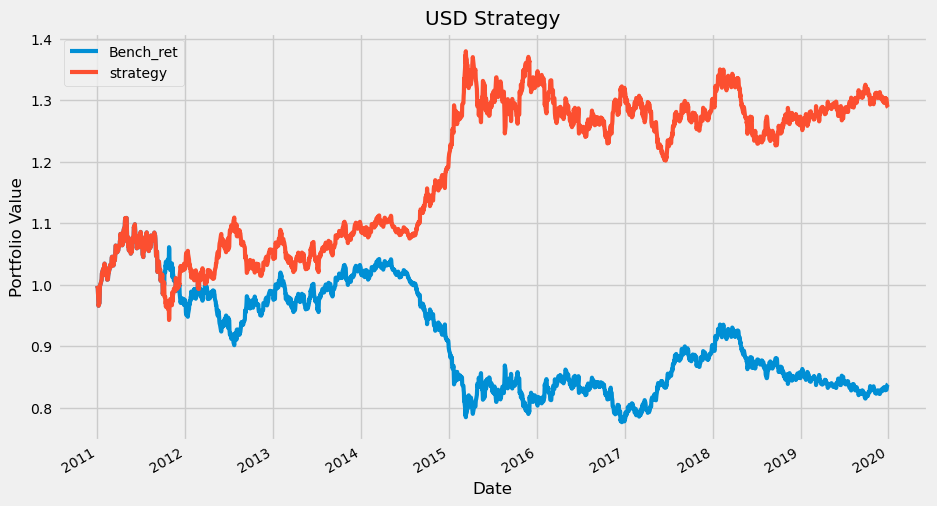

In [20]:
port_values.plot(figsize=(10, 6),
                 title = 'USD Strategy', 
                 ylabel = 'Portfolio Value')

So, is this a "good" strategy? Well, it clearly beats the market in our sample period. An active return, compared to the market, of almost 5% with a volatility of 8.5% it's not that bad... the problem is that when we look at the cumulative performance, we see that the bulk of this overperformance is due to us **being short Euros during the great devaluation of 2014**. It does not seem that this strategy has the power to beat a simple benchmark consistently over time...

___
### Exercise 6.01
In the [Chapter 4](https://learning.oreilly.com/library/view/python-for-algorithmic/9781492053347/ch04.html) of the Hilpisch _Python for Algorithmic Trading_ book, after examining the moving average strategy, we are introduced to a simple **time-series momentum** strategy where we forecast the return of an asset by looking to the cumulative return over the last 3 days. If the cumulative return is positive we will take a long position (buy one unit), if the cumulative return is negative we will take a short position (short-sell one unit).

Using our code above as a template, build a momentum trading strategy.

**STEP 1:** Extract from the DataFrame `raw` the time series of the gold price (`XAU=`) into a new dataframe called `gold`

**STEP 2:** Plot the time series to have a visual understanding of the behaviour of the gold price

**STEP 3:** Build a `signal` column in `gold` containing the "momentum" of gold. In this case we use the return of gold **over the last 3 days**.

$$ momentum = \log \left(\frac{P_{t}}{P_{t-3}}\right)$$

**SPEP 4:** Add a `position` column to `gold` with a long position (`+1`) when the signal is positive and a short position (`-1`) when the signal is negative.

**STEP 5:** Calculate the daily (next-day) returns of Gold in a columns called `future_returns` and create a column `strat_returns` where you multiply the return in time $t+1$ with the position in $t$

**STEP 6:** Create a column called `Benchmark` set equal to `1` to represent a portfolio that is always long on gold. Create a column `Bench_ret` where you calculate the daily return of the benchmark by multiplying `Benchmark` and `future_return`

**STEP 7:** Calculate the total return of your strategy and the total return of the benchmark

**STEP 8:** Plot the return of Gold vs the return of your strategy

___
## 5. In Production
The workflow we have followed so far has led us to the "development" of a strategy: we have devised an alpha model, combined it with a portfolio construction model and we have backtested its performance on historical data. In the industry, our Jupyter Notebook would now be prettyfied with the addition of some more comments and descriptions and would be attached to a presentation of the strategy to be submitted to the investment committee that will decide whether to invest any capital in this strategy.

Assuming that the strategy is "good enough" we will then be asked to put it into production. We cannot expect the investment team to click through all the cells in our notebook every day to find out whether they need to buy or sell Euros. Since we are in charge of the alpha model, our job is to **package the strategy** in a format that is easy to run with **one click**.

The [Chapter 4](https://learning.oreilly.com/library/view/python-for-algorithmic/9781492053347/ch04.html) of the Hilpisch _Python for Algorithmic Trading_ book follows a complicated solution that is beyond our command of Python for now, namely to **create an object**. We have not covered object-oriented programming in our Python introduction, so for now we will pass on this option. If you are interested, [Chapter 6](https://learning.oreilly.com/library/view/python-for-finance/9781492024323/ch06.html) of the _Python for Finance (2nd Ed)_ book covers this topic very well.

Here we will follow a simpler route and will **encapsulate our code in a function**. Basically we take all the relevant code and we use it to create a function that takes some input (the DataFrame with the prices, and the two parameters for the moving averages) runs the function and produces an output.

In [21]:
def SMA_Strategy(prices, SMA1=42, SMA2=252): # notice that we pass 42 and 252 as default values for the parameters
    data = prices.rename('price').to_frame() #Here we change the name so we do not need to worry about the name of the item
    data['SMA1'] = data['price'].rolling(SMA1).mean()
    data['SMA2'] = data['price'].rolling(SMA2).mean()
    data['signal'] = data['SMA1'] - data['SMA2']
    data['position'] = np.sign(data['signal'])
    data.dropna(inplace=True)
    data['returns'] = np.log(data['price'].shift(-1) / data['price'])
    data['strategy'] = data['position'] * data['returns']
    
    ###########
    # Here we have a choice to make in terms of output.
    
    #return data['position']               # this will produce the historical trading position
    #return pd.DataFrame(data['strategy']) # this will produce the daily return of the strategy
    return data['strategy'].sum()    # this will produce the historical total return

The fact that we have to chose what type of output the strategy will return, is one the main limitations of the "function" solution vs the "object" solution. With an object we could create different methods that would produce different outputs. For example `SMA_Strategy.next()` could give us the next trading indications while `SMA_Strategy.performance()` could give us the historical performance... With the function, instead, each function has a single purpose. 

For example, let's now **choose the last output**, the total return. We need to uncomment that line and run the cell. Now we can run the alpha model with a single line and **get the performance of the strategy**:

In [22]:
performance = SMA_Strategy(raw['EUR='], 38, 260)
performance

0.22332585097009722

___
## 6. Optimization
Production is not the only reason why we may want to create a function with our alpha model. Another reason is that we may want to study the performance of the strategy, for example in order to optimize some parameters.

Our SMA strategy has two parameters, the length of the two moving averages. In the development phase we used two numbers that make sense but may not be optimal. Our goal was to get the code to work. Now that we have the function we can optimize it by testing different alternatives. To this end we need to modify the function and select the last output, the average returns. After uncommenting that line (and "commenting back" the other one) we need to run the cell again to update the function.

We can now generate possible combinations of the two parameters and test them:

In [23]:
sma1 = np.linspace(21, 84, 10).astype(int) #notice that we want integer numbers
sma2 = np.linspace(220, 300, 10).astype(int)


for n in range(10):
    
    perf = SMA_Strategy(raw['EUR='], sma1[n], sma2[n])
    print('Performance:', round(perf,4), 'SMA1:', sma1[n], 'SMA2:', sma2[n]) #here we just print the result without saving it
    
    

Performance: 0.2083 SMA1: 21 SMA2: 220
Performance: 0.328 SMA1: 28 SMA2: 228
Performance: 0.2711 SMA1: 35 SMA2: 237
Performance: 0.3511 SMA1: 42 SMA2: 246
Performance: 0.3492 SMA1: 49 SMA2: 255
Performance: 0.2767 SMA1: 56 SMA2: 264
Performance: 0.2102 SMA1: 63 SMA2: 273
Performance: 0.2313 SMA1: 70 SMA2: 282
Performance: 0.0711 SMA1: 77 SMA2: 291
Performance: 0.0643 SMA1: 84 SMA2: 300


We see that `[42/246]` seems to be the winning combination. But we can do better: we can run a double loop where we test **all the possible combinations** between the two parameters. In this case printing the output would be impractical (100 runs) but we can store it in a DataFrame and sort it at the end.

In [24]:
sma1 = np.linspace(21, 84, 10).astype(int)
sma2 = np.linspace(220, 300, 10).astype(int)

#We create an empty list to store the results
results = []

for n1 in range(10):
    for n2 in range(10):
    
        perf = SMA_Strategy(raw['EUR='], sma1[n1], sma2[n2])
        
        #we store the key results of this iteration by appending them to the list
        results.append([perf, sma1[n1], sma2[n2]])

optimization = pd.DataFrame(results, columns=['performance', 'SMA1', 'SMA2'])
optimization.sort_values(by='performance', ascending=False).head(10) #here we can sort and show the Top-10

,performance,SMA1,SMA2
42,0.392240,49,237
62,0.382571,63,237
41,0.382238,49,228
43,0.377160,49,246
81,0.354273,77,228
33,0.351055,42,246
44,0.349235,49,255
32,0.343515,42,237
1,0.339940,21,228
53,0.337696,56,246


We now see that `[49/237]` is the winning combination. Of course we could use more values and do a more granular search, but that is not our objective now. The key idea here, is that once we have encapsulated the model in a single-line fuction we can use it more easily for a variety of purposes.

___
## Exercise 6.02
Now that you know that your momentum function works, let's put it into production by **creating a momentum function** and testing **different values** of the momentum parameter.

Now find the optimal momentum parameter by testing your functions on different "signals" defined as the past returns over the previous $n$ days with $n$ going from 1 to 10.